In [81]:
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from mod.wear import cv2pil, make_hom

out_path = Path('./data/param_check/')
out_path.mkdir(parents=True, exist_ok=True)

# 画像のインライン表示
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # OpenCV は色がGBR順なのでRGB順に並べ替える
    plt.show()

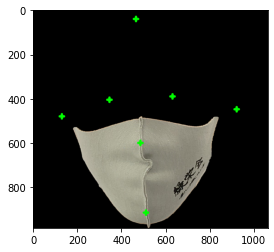

In [84]:
# マスク座標調整
mask_image = cv2.imread('./data/mask/mask.png', -1)
source_parts = {
    "right_eye":  [345, 405], # 右目
    "left_eye":   [630, 390], # 左目
    "nose":       [485, 600], # 鼻
    "jaw":        [510, 915], # アゴ先
    "right_side": [130, 480], # 右耳（向かって左端）
    "left_side":  [920, 448], # 左耳（向かって右端）
    "head_top":   [465, 40]   # おでこ上端
}

for point in source_parts.values():
    cv2.drawMarker(mask_image, tuple(point), (0,255,0,255), thickness=10)

cv2.imwrite(str(out_path/'mask_points.png'), mask_image)
imshow(mask_image)

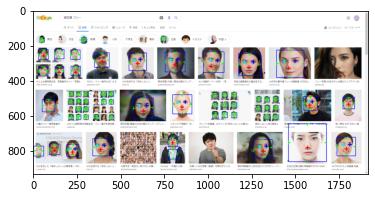

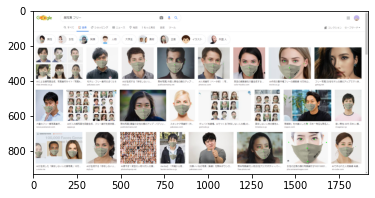

In [85]:
# 顔パーツ座標調整

pathes = {
    'input':    Path('./image/input/'),
    'output':   Path('./image/output/'),
    'cascades': Path('./data/cascades/'),
    'mask':     Path('./data/mask/')
}
pathes['cascades_data'] = {
    'face': pathes['cascades'] / 'haarcascade_frontalface_default.xml',
    'eyes': pathes['cascades'] / 'haarcascade_eye.xml',
    'nose': pathes['cascades'] / 'haarcascade_mcs_nose.xml'
}
pathes['mask_data'] = {
    'image': pathes['mask'] / 'mask.png',
    'parts': pathes['mask'] / 'mask_parts.json'
}

# カスケード分類器
classifiers = {
    name:cv2.CascadeClassifier(str(pathes['cascades_data'][name]))
    for name in pathes['cascades_data']
}

# 推定した領域の中心座標を返す
# 複数個見つかった場合はリスト順で0番目
def parts_centers(name, roi, classifiers):
    areas = classifiers[name].detectMultiScale(roi, 1.05, 10)
    if len(areas)==0:
        return None
    else:
        return [[ex+int(ew/2), ey+int(eh/2)] for ex, ey, ew, eh in areas][0]

# 両目が判定できているときのみそれぞれの中心座標を返す
# 返り値:(right_eye, left_eye) or (None, None)
def eyes_centers(roi, classifiers):
    areas = classifiers.detectMultiScale(roi, 1.05, 10)
    if len(areas)==2:
        points = [[ex+int(ew/2), ey+int(eh/2)] for ex, ey, ew, eh in areas]
        # x座標が最も小さいのが右目、最も大きいのが左目
        right_index = np.argmin(points, axis=0)[0]
        left_index = np.argmax(points, axis=0)[0]
        return (points[right_index], points[left_index])
    else:
        return (None, None)

# 認識した顔からパーツの座標を取得
# 見つからなかった場合はNone
def get_dest_parts(roi, classifiers):
    w, h = roi.shape
    eyes = eyes_centers(roi, classifiers['eyes'])
    eyes_exist = eyes[0] is not None

    # 両目の傾きで上下左右を修正
    eye_grad = (eyes[1][1]-eyes[0][1])/(eyes[1][0]-eyes[0][0]) if eyes_exist else 0
    
    return {
        'right_eye':  eyes[0],
        'left_eye':   eyes[1],
        'nose':       parts_centers('nose', roi, classifiers),
        'jaw':        [int(w/2 - eye_grad*h/2), h],
        'right_side': [0, int(h/2 - eye_grad*w/2)],
        'left_side':  [w, int(h/2 + eye_grad*w/2)],
        'head_top':   [int(w/2 + eye_grad*h/2), 0]
    }

input_path = Path('./image/input/sample.png')
input_img = cv2.imread(str(input_path))
input_gray = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
input_image_PIL = Image.open(input_path)

faces = classifiers['face'].detectMultiScale(input_gray, 1.05, 10)
for (x,y,w,h) in faces:
    input_img = cv2.rectangle(input_img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = input_gray[y:y+h, x:x+w]
    roi_color = input_img[y:y+h, x:x+w]

    eye = eyes_centers(roi_gray, classifiers['eyes'])
    dest_parts = get_dest_parts(roi_gray, classifiers)

    # 座標がNoneでないパーツを取得
    exist_parts = [p for p in dest_parts if dest_parts[p] is not None]

    # ホモグラフィー変換の起点と終点
    source_points = np.array([source_parts[part] for part in exist_parts], dtype=np.float32)
    dest_points = np.array([dest_parts[part] for part in exist_parts], dtype=np.float32)

    # 幾何変換行列作成
    mat = make_hom(source_points, dest_points)

    # マスク画像を幾何変換しROIの大きさにする
    perspective_mask_image = cv2.warpPerspective(mask_image, mat, (2*w,2*h))

    perspective_mask_image_PIL = cv2pil(perspective_mask_image)
    input_image_PIL.paste(perspective_mask_image_PIL, (x, y), perspective_mask_image_PIL)

    for part in dest_parts:
        if dest_parts[part] is not None:
            if part=='right_eye': color = (255,255,0,255)
            elif part=='left_eye': color = (255,0,0,255)
            elif part=='nose': color = (0,0,255,255)
            else: color = (0,255,0,255)
            cv2.drawMarker(roi_color, tuple(dest_parts[part]), color, thickness=3)

cv2.imwrite(str(out_path/'face_points.png'), input_img)
imshow(input_img)
input_image_PIL.save(str(out_path/'wear_check.png'))
plt.imshow(np.array(input_image_PIL))